<a href="https://colab.research.google.com/github/klaasmeinke/CNNs-exoplanet-cartography/blob/main/NN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Thesis'

%run Create_Data.ipynb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

from tabulate import tabulate

keras.backend.set_floatx('float64')
print("num GPUs Avilable: ", len(tf.config.experimental.list_physical_devices('GPU')))

Mounted at /content/drive
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
num GPUs Avilable:  1


In [ ]:
for incl in [0, 30, 60, 90]:
    axes = np.load('data/axes.npy')
    incl_vector = np.array([np.sin(incl * np.pi/180), 0, np.cos(incl * np.pi/180)])
    # mses = np.array([np.mean((np.abs(axis) - np.abs(incl_vector))**2) for axis in axes])
    mses = np.array([np.mean((axis - incl_vector)**2) for axis in axes])
    axis_ind = np.argmin(mses)
    axis = axes[axis_ind]
    print(angle(axis, incl_vector)*180/np.pi)

23.32886221986279
10.917421319466778
5.055923540897552
15.007900698222121


#### A function to create human readable confusion matrices

In [ ]:
def print_confusion(model, curves, stypes, val_split = 0.1):
    y_test = stypes[ - int(val_split * len(stypes)): ].reshape(-1,4)
    y_pred = model.predict(curves[- int(val_split * len(curves)):]).reshape(-1,4)

    conf = tf.math.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    conf /= np.sum(conf, axis = 0)
    conf = np.round(conf, decimals = 2)

    labels = ['Ocean', 'Desert', 'Veget.', 'Clouds']
    headers = np.insert(labels, 0, 'Pred.')

    print(tabulate(np.c_[labels, conf], headers = headers))

### Earth Curves

In [ ]:
# # CREATE CURVES
axes = np.load('data/axes.npy')
# c = earth_curves(rot_axis = axes[57], incl = 30)
c2 = earth_curves(rot_axis = axes[57], incl = 30*np.pi/180, clouds_ind = 21)
# c_lamb = earth_curves(rot_axis = axes[57], incl = 30, fourier = False)
c2_lamb = earth_curves(rot_axis = axes[57], incl = 30*np.pi/180, clouds_ind = 21,
                       fourier = False)

# cx = c[:,:,:,:2]
# cx = cx.reshape((1,8,8,12))

cx2 = c2[:,:,:,:2]
cx2 = cx2.reshape((1,8,8,12))

# # MAKE THE MAPS
sx_true = np.load('data/earth_surface_types.npy')
sx_true2 = np.maximum(sx_true, clouds[21] * 3)

# PLOT
# mollweide(faces, sx_true)
# plot_fluxes(c[:,:,:,0])
# plot_fluxes(c_lamb, new_fig = False, linestyle='dotted')
# add_legend(labels = ['Directional', 'Lambertian'])
# plt.title('Total Flux')

# plot_fluxes(c[:,:,:,1])
# plot_fluxes(c[:,:,:,2], new_fig = False, linestyle='dotted')
# add_legend(labels = ['Q', 'U'])
# plt.title('Polarized Flux')
# plt.show()

# print()
# print()

mollweide(faces, sx_true2)
plot_fluxes(c2[:,:,:,0])
plot_fluxes(c2_lamb, new_fig = False, linestyle='dotted')
add_legend(labels = ['Directional', 'Lambertian'])
plt.title('Total Flux')

plot_fluxes(c2[:,:,:,2], linestyle='dotted')
plot_fluxes(c2[:,:,:,1], new_fig = False)
add_legend(labels = ['Q', 'U'])
plt.title('Polarized Flux')
plt.ylim([-0.069, 0.004])
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convolution Functions

In [ ]:
def conv_curves(x, kernel_size = 1, filters = 1, activation = None, stride = 1,
                use_bias = True):
    idx = tf.constant(list(range(8)) + list(range(kernel_size - 1)))

    x = Lambda(lambda x: tf.gather(x, idx, axis = 2))(x)
    x = Conv2D(filters = filters, kernel_size = (1, kernel_size),
               padding = 'valid', activation = activation,
               strides = (1,stride), use_bias = use_bias)(x)

    return x

In [ ]:
idx_0 = np.array(range(1000))
idx_1 = np.load('data/fib_convolutions/idx_1.npy')
idx_2 = np.load('data/fib_convolutions/idx_2.npy')
idx_3 = np.load('data/fib_convolutions/idx_3.npy')
idx_4 = np.load('data/fib_convolutions/idx_4.npy')
idx_5 = np.load('data/fib_convolutions/idx_5.npy')

def sphere_conv(x, rings = 1, filters = 4, axis = 0, activation = None):
    kernel_size = [1, 13, 37, 72, 118, 174][rings]
    idx = [idx_0, idx_1, idx_2, idx_3, idx_4, idx_5][rings]

    # remove all rows for which the facet is not visible:
    vis = visible_facets(axis_idx = axis)
    bad_idx = np.where(vis == 0)[0]
    good_idx = np.where(vis == 1)[0]

    idx = idx.reshape((1000, kernel_size))
    idx = np.delete(idx, bad_idx, axis = 0)

    # repeat some elements if there are elements that aren't visible in the rows
    idx = np.array([row[[np.where(np.amax(row[None, :ind + 1] == good_idx[:, None],
                                          axis = 0))[0][-1]
                         for ind in range(len(row))]]
                    for row in idx])

    # change the indices to match the new indexing:
    idx = idx.reshape((-1))
    idx -= np.array([np.count_nonzero(vis[:i] == 0) for i in idx])

    x = Lambda(lambda x: tf.gather(x, idx, axis = 1))(x)
    x = Conv1D(filters = filters, kernel_size = kernel_size,
               strides = kernel_size, activation = activation,
               kernel_initializer='zeros', bias_initializer='zeros')(x)

    return x

##### Demonstrating repeating some elements

In [ ]:
# arr = np.array([1,2,3,4,5,6,7,8])

# test = np.array([1,3,5,6,4])

# print(arr[[np.where(np.amax(arr[None, :ind + 1] == test[:, None], axis = 0))[0][-1]
#           for ind in range(len(arr))]])

[1 1 3 4 5 6 6 6]


# Create Models

In [ ]:
def create_model(fourier = True, polarization = True, axis = 0):

    # input shapes:
    if fourier and polarization:
        input_shape = (8,8,12)
    else:
        input_shape = (8,8,6)

    # number of visible facets:
    num_vis_facets = np.sum(visible_facets(axis_idx = axis))

    # ARCHITECTURE:
    # curve convolutions:
    inputs = keras.Input(shape = input_shape)
    # x = conv_curves(inputs, kernel_size = 3, filters = 16)
    # x = conv_curves(x, kernel_size = 4, stride = 1, filters = 16)
    x = conv_curves(inputs, kernel_size = 2, filters = 16)
    x = conv_curves(x, kernel_size = 2, stride = 1, filters = 16)

    # dense layer:
    x = Flatten()(x)
    x = Dense(num_vis_facets * 4)(x)
    output_block_1 = Reshape((num_vis_facets,4))(x)

    # spherical convolutions:
    x = sphere_conv(output_block_1, rings = 1, filters = 4, axis = axis)
    output_block_2 = add([x, output_block_1])

    x = sphere_conv(output_block_2, rings = 1, filters = 4, axis = axis)
    output_block_3 = add([x, output_block_2])

    x = sphere_conv(output_block_3, rings = 1, filters = 4, axis = axis)
    output_block_4 = add([x, output_block_3])

    x = sphere_conv(output_block_4, rings = 1, filters = 4, axis = axis)
    output_block_5 = add([x, output_block_4])

    x = sphere_conv(output_block_5, rings = 1, filters = 4, axis = axis)
    output_block_6 = add([x, output_block_5])

    output = Flatten()(output_block_6)

    # create and show architecture:
    model = keras.Model(inputs, output)
    model.compile(optimizer = 'adam', loss='mse')

    model.summary()
    keras.utils.plot_model(model, show_shapes=True)

    # load weights
    # if fourier and polarization:
    #     model.load_weights('models/classification/fourier_pol/axis_' + str(axis))
    # elif fourier and not polarization:
    #     model.load_weights('models/classification/fourier/axis_' + str(axis))
    # elif not fourier:
    #     model.load_weights('models/classification/lambertian/axis_' + str(axis))

    return model

# Results

##### Testing

In [ ]:
create_model(axis = 34)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 12)]   0           []                               
                                                                                                  
 lambda_7 (Lambda)              (None, 8, 10, 12)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 16)     592         ['lambda_7[0][0]']               
                                                                                                  
 lambda_8 (Lambda)              (None, 8, 11, 16)    0           ['conv2d_2[0][0]']               
                                                                                            

### Different Geometries

In [ ]:
# CHANGE NNUMBER OF EPOCHS BEFORE UPLOADING!

incl = 0

for axis_ind in [i for i in range(64) if axes[i, 0] >= 0][:3]:

    # print()
    # print()

    # axes = np.load('data/axes.npy')
    # print('axis = ' + str(axes[axis_ind]))

    model = create_model(axis = axis_ind)
    load_data(i = incl, axis_idx = axis_ind)

    model.fit(
        curves,
        stypes,
        epochs = 1,
        batch_size = 64,
        validation_split = 0.1,
        callbacks=[keras.callbacks.EarlyStopping(patience=10)]
    )

    # print_confusion(model, curves, stypes)
    model.save_weights('models/classification/fourier_pol/axis' + str(axis_ind)\
                       + '_i' + str(incl))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8, 8, 12)]   0                                            
__________________________________________________________________________________________________
lambda_42 (Lambda)              (None, 8, 10, 12)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 8, 16)     592         lambda_42[0][0]                  
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 8, 10, 16)    0           conv2d_12[0][0]                  
____________________________________________________________________________________________

### Different Noise Levels

TRUTH


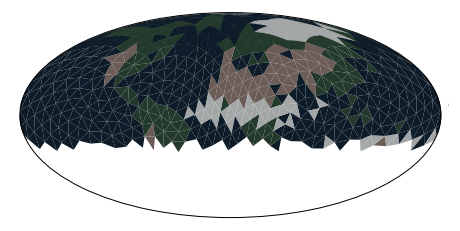

In [ ]:
print('TRUTH')

earth = np.load('data/earth_surface_types.npy')

vis_facets = visible_facets(axis_idx=57).astype('bool')

mollweide(faces[vis_facets], combine(earth, clouds[21])[vis_facets])

In [ ]:
clouds[21, vis_facets].shape

(681,)

#### Fourier and Polarization

##### Create Model and Save Weights

In [ ]:
# model_fou_pol = create_model(fourier = True, polarization = True, axis = 57)
# load_data(i = 30, axis_idx = 57)

# model_fou_pol.fit(
#     curves,
#     stypes,
#     epochs = 100,
#     batch_size = 32,
#     validation_split = 0.1,
#     callbacks = [keras.callbacks.EarlyStopping(patience=10)]
# )

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 8, 8, 12)]   0                                            
__________________________________________________________________________________________________
lambda_154 (Lambda)             (None, 8, 10, 12)    0           input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 8, 8, 16)     592         lambda_154[0][0]                 
__________________________________________________________________________________________________
lambda_155 (Lambda)             (None, 8, 11, 16)    0           conv2d_44[0][0]                  
___________________________________________________________________________________________

In [ ]:
# model_fou_pol.save_weights('models/i30/fou_pol_axis_57')

##### Test Different Noise Levels

In [ ]:
model_fou_pol = create_model(fourier = True, polarization = True, axis = 57)

print('NO NOISE')

model_fou_pol.load_weights('models/i30/fou_pol_axis_57')
load_data(i = 30, axis_idx = 57)

print_confusion(model_fou_pol, curves, stypes, val_split = 0.1)

sx_pred = model_fou_pol.predict(c2[:,:,:,:2].reshape((1,8,8,12)))[0]
sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

mollweide(faces[visible_facets(axis_idx = 57).astype('bool')],
          sx_pred)
plt.show()

for N_max in [100000, 10000, 1000, 100, 10]:

    print()
    print()
    print('N_MAX = ' + str(N_max))

    load_data(N_max = N_max, i = 30, axis_idx = 57)
    model_fou_pol.load_weights('models/i30/fou_pol_axis_57_Nmax_new' + str(N_max))

    # model_fou_pol.fit(
    #     curves,
    #     stypes,
    #     epochs = 0,
    #     batch_size = 64,
    #     validation_split = 0.1,
    #     callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    # )

    # model_fou_pol.save_weights('models/i30/fou_pol_axis_57_Nmax_' + str(N_max))

    # print the confusion matrices:
    print_confusion(model_fou_pol, curves, stypes, val_split = 0.1)

    # show the earth:
    noise_earth_curves = noise_curves(c2[:,:,:,:2], N_max = N_max)
    noise_earth_curves = noise_earth_curves.reshape((1,8,8,12))
    noise_earth_curves = normalize(noise_earth_curves)

    sx_pred = model_fou_pol.predict(noise_earth_curves)[0]
    sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

    mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
    plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 12)]        0         
_________________________________________________________________
lambda (Lambda)              (None, 8, 10, 12)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 16)          592       
_________________________________________________________________
lambda_1 (Lambda)            (None, 8, 11, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          1040      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2724)              279210

<IPython.core.display.Javascript object>



N_MAX = 100000
curves:  (8956, 8, 8, 12)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)


NotFoundError: ignored

## Fourier

##### Create Model and Train Weights

In [ ]:
# model_fou = create_model(fourier = True, polarization = False, axis = 57)
# load_data(polarization = False, i = 30, axis_idx = 57)

# model_fou.fit(
#     curves,
#     stypes,
#     epochs = 250,
#     batch_size = 64,
#     validation_split = 0.1,
#     callbacks = [keras.callbacks.EarlyStopping(patience=10)]
# )

In [ ]:
# model_fou.save_weights('models/i30/fou_axis_57')

##### Different Noise Levels

In [ ]:
model_fou = create_model(fourier = True, polarization = False, axis = 57)

print('NO NOISE')
# model_fou.load_weights('models/i30/fou_axis_57')
load_data(i = 30, axis_idx = 57, polarization = False)
curves[:,:,:,3] = 0
stypes = stypes.reshape((-1, 2724))

model_fou.fit(
    curves,
    stypes,
    epochs = 1000,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
)

# model_fou.save_weights('models/i30/fou_axis_57_new')

print_confusion(model_fou, curves, stypes, val_split = 0.1)

# sx_pred = model_fou.predict(c2[:,:,:,0].reshape((1,8,8,6)))[0]
# sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

# mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
# plt.show()

# for N_max in [100000, 10000, 1000, 100, 10]:

#     print()
#     print()
#     print('N_MAX = ' + str(N_max))

#     load_data(N_max = N_max, polarization = False, i = 30, axis_idx = 57)
#     model_fou.load_weights('models/i30/fou_axis_57_Nmax_' + str(N_max))

#     model_fou.fit(
#         curves,
#         stypes,
#         epochs = 100,
#         batch_size = 64,
#         validation_split = 0.1,
#         callbacks = [keras.callbacks.EarlyStopping(patience=10)]
#     )
#     model_fou.save_weights('models/i30/fou_axis_57_Nmax_' + str(N_max) + '_new')

#     # print the confusion matrices:
#     print_confusion(model_fou, curves, stypes, val_split = 0.1)

#     # show the earth:
#     noise_earth_curves = noise_curves(c2[:,:,:,0], N_max = N_max,
#                                       polarization = False)
#     noise_earth_curves = noise_earth_curves.reshape((1,8,8,6))
#     noise_earth_curves = normalize(noise_earth_curves)

#     sx_pred = model_fou.predict(noise_earth_curves)[0]
#     sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

#     mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
#     plt.show()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8, 8, 6)]    0           []                               
                                                                                                  
 lambda_28 (Lambda)             (None, 8, 9, 6)      0           ['input_5[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 8, 8, 16)     208         ['lambda_28[0][0]']              
                                                                                                  
 lambda_29 (Lambda)             (None, 8, 9, 16)     0           ['conv2d_8[0][0]']               
                                                                                            

In [ ]:
model_fou = create_model(fourier = True, polarization = False, axis = 57)

print('NO NOISE')
load_data(i = 30, axis_idx = 57, polarization = False)
curves[:,:,:,0] = 0
stypes = stypes.reshape((-1, 2724))

model_fou.fit(
    curves,
    stypes,
    epochs = 1000,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
)

print_confusion(model_fou, curves, stypes, val_split = 0.1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 6)]    0           []                               
                                                                                                  
 lambda (Lambda)                (None, 8, 9, 6)      0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 16)     208         ['lambda[0][0]']                 
                                                                                                  
 lambda_1 (Lambda)              (None, 8, 9, 16)     0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
model_fou = create_model(fourier = True, polarization = False, axis = 57)

print('NO NOISE')
# model_fou.load_weights('models/i30/fou_axis_57')
load_data(i = 30, axis_idx = 57, polarization = False)
curves = curves[:,1::2]
stypes = stypes.reshape((-1, 2724))

model_fou.fit(
    curves,
    stypes,
    epochs = 150,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
)

# model_fou.save_weights('models/i30/fou_axis_57_new')

print_confusion(model_fou, curves, stypes, val_split = 0.1)

# sx_pred = model_fou.predict(c2[:,:,:,0].reshape((1,8,8,6)))[0]
# sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

# mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
# plt.show()

# for N_max in [100000, 10000, 1000, 100, 10]:

#     print()
#     print()
#     print('N_MAX = ' + str(N_max))

#     load_data(N_max = N_max, polarization = False, i = 30, axis_idx = 57)
#     model_fou.load_weights('models/i30/fou_axis_57_Nmax_' + str(N_max))

#     model_fou.fit(
#         curves,
#         stypes,
#         epochs = 100,
#         batch_size = 64,
#         validation_split = 0.1,
#         callbacks = [keras.callbacks.EarlyStopping(patience=10)]
#     )
#     model_fou.save_weights('models/i30/fou_axis_57_Nmax_' + str(N_max) + '_new')

#     # print the confusion matrices:
#     print_confusion(model_fou, curves, stypes, val_split = 0.1)

#     # show the earth:
#     noise_earth_curves = noise_curves(c2[:,:,:,0], N_max = N_max,
#                                       polarization = False)
#     noise_earth_curves = noise_earth_curves.reshape((1,8,8,6))
#     noise_earth_curves = normalize(noise_earth_curves)

#     sx_pred = model_fou.predict(noise_earth_curves)[0]
#     sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

#     mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
#     plt.show()

(8956, 4, 8, 6)

## Lambertian

##### Create Model

In [ ]:
# model_lamb = create_model(fourier = False, polarization = False, axis = 57)
# load_data(polarization = False, fourier = False, i = 30, axis_idx = 57)

# model_lamb.fit(
#     curves,
#     stypes,
#     epochs = 250,
#     batch_size = 64,
#     validation_split = 0.1,
#     callbacks = [keras.callbacks.EarlyStopping(patience=10)]
# )

In [ ]:
# model_lamb.save_weights('models/i30/lamb_axis_57')

##### Different Noise Levels

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
lambda_42 (Lambda)              (None, 8, 10, 6)     0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 8, 16)     304         lambda_42[0][0]                  
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 8, 11, 16)    0           conv2d_12[0][0]                  
____________________________________________________________________________________________

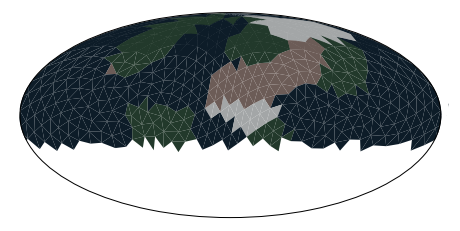

curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 1s 51ms/step - loss: 3.5207
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.29      0.29      0.06      0.13
Desert      0.24      0.35      0.08      0.11
Veget.      0.21      0.14      0.77      0.13
Clouds      0.26      0.23      0.09      0.64


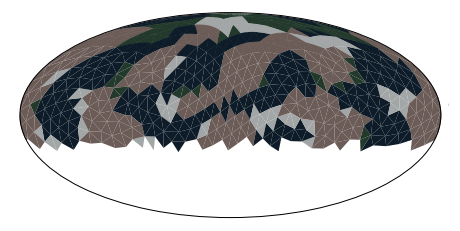



N_MAX = 100000
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 1s 49ms/step - loss: 0.0753
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.85      0.07      0.05      0.07
Desert      0.07      0.82      0.09      0.08
Veget.      0.03      0.06      0.81      0.06
Clouds      0.05      0.05      0.05      0.78


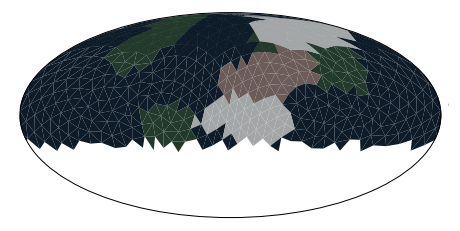

curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 2s 56ms/step - loss: 1.1779
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.3       0.3       0.04      0.18
Desert      0.25      0.48      0.09      0.15
Veget.      0.18      0.07      0.78      0.14
Clouds      0.27      0.15      0.09      0.53


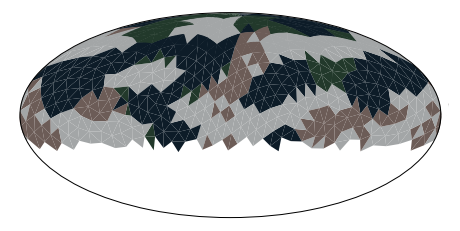



N_MAX = 10000
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 1s 48ms/step - loss: 0.0842
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.83      0.08      0.05      0.08
Desert      0.08      0.78      0.11      0.09
Veget.      0.04      0.07      0.78      0.07
Clouds      0.05      0.07      0.06      0.76


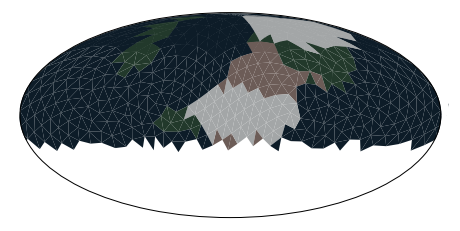

curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 1s 49ms/step - loss: 0.5389
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.35      0.21      0.04      0.21
Desert      0.22      0.59      0.1       0.14
Veget.      0.16      0.06      0.78      0.12
Clouds      0.27      0.13      0.08      0.53


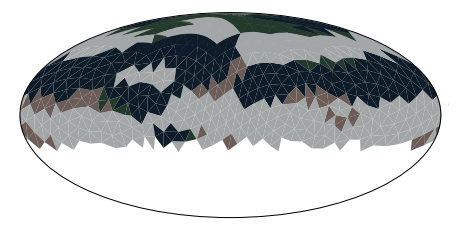



N_MAX = 1000
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 1s 50ms/step - loss: 0.0989
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.76      0.09      0.07      0.08
Desert      0.11      0.7       0.12      0.09
Veget.      0.06      0.1       0.72      0.07
Clouds      0.08      0.11      0.09      0.76


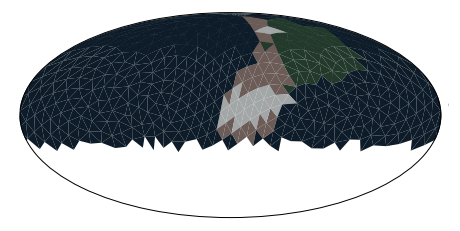

curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 2s 61ms/step - loss: 0.2748
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.54      0.16      0.06      0.21
Desert      0.16      0.59      0.11      0.11
Veget.      0.12      0.1       0.74      0.09
Clouds      0.18      0.15      0.09      0.58


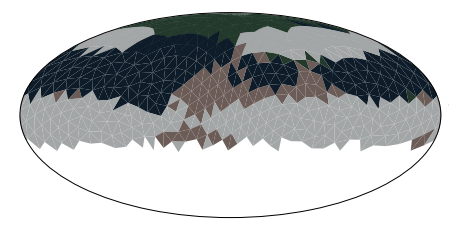



N_MAX = 100
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 2s 58ms/step - loss: 0.1198
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.7       0.11      0.1       0.09
Desert      0.12      0.62      0.14      0.14
Veget.      0.07      0.11      0.64      0.08
Clouds      0.11      0.16      0.12      0.69


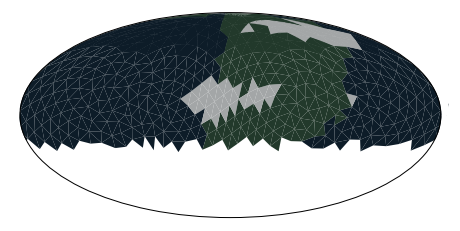

curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 2s 57ms/step - loss: 0.1864
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.73      0.16      0.1       0.21
Desert      0.1       0.61      0.14      0.14
Veget.      0.08      0.11      0.68      0.1
Clouds      0.08      0.12      0.09      0.56


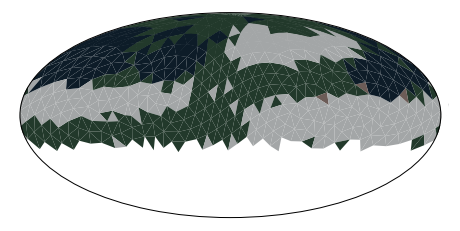



N_MAX = 10
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 2s 57ms/step - loss: 0.1444
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.57      0.1       0.1       0.11
Desert      0.16      0.51      0.16      0.19
Veget.      0.11      0.15      0.61      0.1
Clouds      0.16      0.24      0.13      0.6


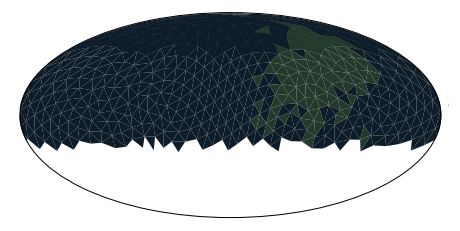

curves:  (8956, 8, 8, 6)
combos:  (8956, 4)
axes:    (8956, 3)
stypes:  (8956, 681, 4)
28/28 [==============================] - 2s 64ms/step - loss: 0.1595
Pred.      Ocean    Desert    Veget.    Clouds
-------  -------  --------  --------  --------
Ocean       0.64      0.14      0.12      0.19
Desert      0.13      0.52      0.16      0.19
Veget.      0.11      0.15      0.6       0.1
Clouds      0.12      0.19      0.12      0.52


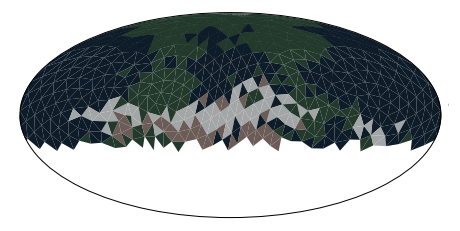

In [ ]:
# model_lamb = create_model(polarization = False, fourier = False, axis = 57)
# model_lamb.load_weights('models/i30/lamb_axis_57')

# print('NO NOISE')

# for earth_curve, label, fourier in zip([c2_lamb, c2[:,:,:,0]],
#                                        ['lambertian curve retrieval:',
#                                         'fourier curve retrieval:'],
#                                        [False, True]):
#     load_data(polarization = False, fourier = fourier, i = 30, axis_idx = 57)
#     # print the val loss:
#     model_lamb.evaluate(curves[int(-0.1 * len(curves)):],
#                         stypes[int(-0.1 * len(stypes)):])

#     # print the confusion matrices:
#     print_confusion(model_lamb, curves, stypes, val_split = 0.1)

#     # show the earth:
#     sx_pred = model_lamb.predict(earth_curve.reshape((1,8,8,6)))[0]
#     sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

#     mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
#     plt.show()

# for N_max in [100000, 10000, 1000, 100, 10]:

#     print()
#     print()
#     print('N_MAX = ' + str(N_max))

#     load_data(N_max = N_max, polarization = False, fourier = False,
#               i = 30, axis_idx = 57)
#     model_lamb.load_weights('models/i30/lamb_axis_57_Nmax_' + str(N_max))
#     # model_lamb.fit(
#     #     curves,
#     #     stypes,
#     #     epochs = 50,
#     #     batch_size = 64,
#     #     validation_split = 0.1,
#     #     callbacks = [keras.callbacks.EarlyStopping(patience=10)]
#     # )

#     # model_lamb.save_weights('models/i30/lamb_axis_57_Nmax_' + str(N_max))

#     # now evaluate on lambertian and fourier curves:
#     for earth_curve, label, fourier in zip([c2_lamb, c2[:,:,:,0]],
#                                            ['lambertian curve retrieval:',
#                                             'fourier curve retrieval:'],
#                                            [False, True]):

#         load_data(N_max = N_max, polarization = False, fourier = fourier, i = 30,
#                   axis_idx = 57)
#         # print the val loss:
#         model_lamb.evaluate(curves[int(-0.1 * len(curves)):],
#                             stypes[int(-0.1 * len(stypes)):])

#         # print the confusion matrices:
#         print_confusion(model_lamb, curves, stypes, val_split = 0.1)

#         # show the earth:
#         noise_earth_curves = noise_curves(earth_curve, N_max = N_max,
#                                           polarization = False)
#         noise_earth_curves = noise_earth_curves.reshape((1,8,8,6))
#         noise_earth_curves = normalize(noise_earth_curves)

#         sx_pred = model_lamb.predict(noise_earth_curves)[0]
#         sx_pred = np.argmax(sx_pred, axis = 1).astype(int)

#         mollweide(faces[visible_facets(axis_idx = 57).astype('bool')], sx_pred)
#         plt.show()

# Testing Softmax/Sigmoid

In [ ]:
# def create_model(fourier = True, polarization = True, axis = 0):

#     # input shapes:
#     if fourier and polarization:
#         input_shape = (8,8,12)
#     else:
#         input_shape = (8,8,6)

#     # number of visible facets:
#     num_vis_facets = np.sum(visible_facets(axis_idx = axis))

#     # ARCHITECTURE:
#     # curve convolutions:
#     inputs = keras.Input(shape = input_shape)
#     x = conv_curves(inputs, kernel_size = 3, filters = 16)
#     x = conv_curves(x, kernel_size = 4, stride = 1, filters = 16)

#     # dense layer:
#     x = Flatten()(x)
#     x = Dense(num_vis_facets * 4)(x)
#     x = Reshape((num_vis_facets,4))(x)
#     output_block_1 = Activation('softmax')(x)

#     # spherical convolutions:
#     x = sphere_conv(output_block_1, rings = 1, filters = 4, axis = axis)
#     output_block_2 = add([x, output_block_1])

#     x = sphere_conv(output_block_2, rings = 1, filters = 4, axis = axis)
#     output_block_3 = add([x, output_block_2])

#     x = sphere_conv(output_block_3, rings = 1, filters = 4, axis = axis)
#     output_block_4 = add([x, output_block_3])

#     x = sphere_conv(output_block_4, rings = 1, filters = 4, axis = axis)
#     output_block_5 = add([x, output_block_4])

#     x = sphere_conv(output_block_5, rings = 1, filters = 4, axis = axis)
#     output_block_6 = add([x, output_block_5])

#     # output = Flatten()(output_block_6)

#     # create and show architecture:
#     model = keras.Model(inputs, output_block_6)
#     model.compile(optimizer = 'adam', loss='mse')

#     model.summary()
#     keras.utils.plot_model(model, show_shapes=True)

#     return model

In [ ]:
# model = create_model(axis = 57)
# op = model.predict(np.random.rand(1, 8,8,12))[0]
# print(np.sum(op, axis = 1))

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 8, 8, 12)]   0                                            
__________________________________________________________________________________________________
lambda_77 (Lambda)              (None, 8, 10, 12)    0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 8, 8, 16)     592         lambda_77[0][0]                  
__________________________________________________________________________________________________
lambda_78 (Lambda)              (None, 8, 11, 16)    0           conv2d_22[0][0]                  
___________________________________________________________________________________________

In [ ]:
# # model_fou = create_model(fourier = True, polarization = False, axis = 57)

# # print('NO NOISE')
# # model_fou.load_weights('models/i30/fou_axis_57')
# # load_data(i = 30, axis_idx = 57, polarization = False)

# model_fou.fit(
#     curves,
#     stypes,
#     epochs = 15,
#     batch_size = 64,
#     validation_split = 0.1,
#     callbacks = [keras.callbacks.EarlyStopping(patience=10)]
# )


# print_confusion(model_fou, curves, stypes, val_split = 0.1)

Epoch 1/15
126/126 [==============================] - 36s 286ms/step - loss: 0.0583 - val_loss: 0.0602
Epoch 2/15
126/126 [==============================] - 36s 286ms/step - loss: 0.0582 - val_loss: 0.0602
Epoch 3/15
126/126 [==============================] - 36s 287ms/step - loss: 0.0583 - val_loss: 0.0606
Epoch 4/15
126/126 [==============================] - 36s 289ms/step - loss: 0.0582 - val_loss: 0.0604
Epoch 5/15
126/126 [==============================] - 37s 297ms/step - loss: 0.0581 - val_loss: 0.0605
Epoch 6/15
126/126 [==============================] - 37s 294ms/step - loss: 0.0580 - val_loss: 0.0602
Epoch 7/15
126/126 [==============================] - 38s 298ms/step - loss: 0.0581 - val_loss: 0.0601
Epoch 8/15
126/126 [==============================] - 37s 297ms/step - loss: 0.0580 - val_loss: 0.0606
Epoch 9/15
126/126 [==============================] - 37s 296ms/step - loss: 0.0579 - val_loss: 0.0600
Epoch 10/15
126/126 [==============================] - 37s 296ms/step - l

# Different Inclinations

In [ ]:
for i in [0, 15, 30, 45, 60, 75, 90]:

    axes = np.load('data/axes.npy')
    incl_vector = np.array([np.sin(i * np.pi/180), 0, np.cos(i * np.pi/180)])
    mses = np.array([np.mean((axis - incl_vector)**2) for axis in axes])
    axis_ind = np.argmin(mses)
    axis = axes[axis_ind]

    # fou_pol:
    # model = create_model(fourier = True, polarization = True, axis = int(axis_ind))
    # load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = True,
    #             maps = True, polarization = True)
    # name = 'fou_pol'
    # fou:
    # model = create_model(fourier = True, polarization = False, axis = axis_ind)
    # load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = True,
    #             maps = True, polarization = False)
    # name = 'fou'
    # lamb:
    # model = create_model(fourier = False, polarization = False, axis = int(axis_ind))
    # load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = False,
    #             maps = True, polarization = False)
    # name = 'lamb'

    # model.fit(
    # curves,
    # stypes,
    # epochs = 1000,
    # batch_size = 64,
    # validation_split = 0.1,
    # callbacks = [keras.callbacks.EarlyStopping(patience=5)]
    # )
    # model.save_weights('models/i' + str(i) + '/' + name + '_axis' + str(int(axis_ind)))
    # model.load_weights('models/i' + str(i) + '/' + name + '_axis' + str(int(axis_ind)))

    # testing:
    name = 'lamb'
    model = create_model(fourier = False, polarization = False, axis = int(axis_ind))
    model.load_weights('models/i' + str(i) + '/' + name + '_axis' + str(int(axis_ind)))
    load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = True,
                maps = True, polarization = False)
    print_confusion(model, curves, stypes, val_split = 0.1)
    # name = 'fou'
    # model = create_model(fourier = True, polarization = False, axis = int(axis_ind))
    # model.load_weights('models/i' + str(i) + '/' + name + '_axis' + str(int(axis_ind)))
    # load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = True,
    #             maps = True, polarization = False)
    # print_confusion(model, curves, stypes, val_split = 0.1)


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
lambda_91 (Lambda)              (None, 8, 10, 6)     0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 8, 8, 16)     304         lambda_91[0][0]                  
__________________________________________________________________________________________________
lambda_92 (Lambda)              (None, 8, 11, 16)    0           conv2d_26[0][0]                  
___________________________________________________________________________________________

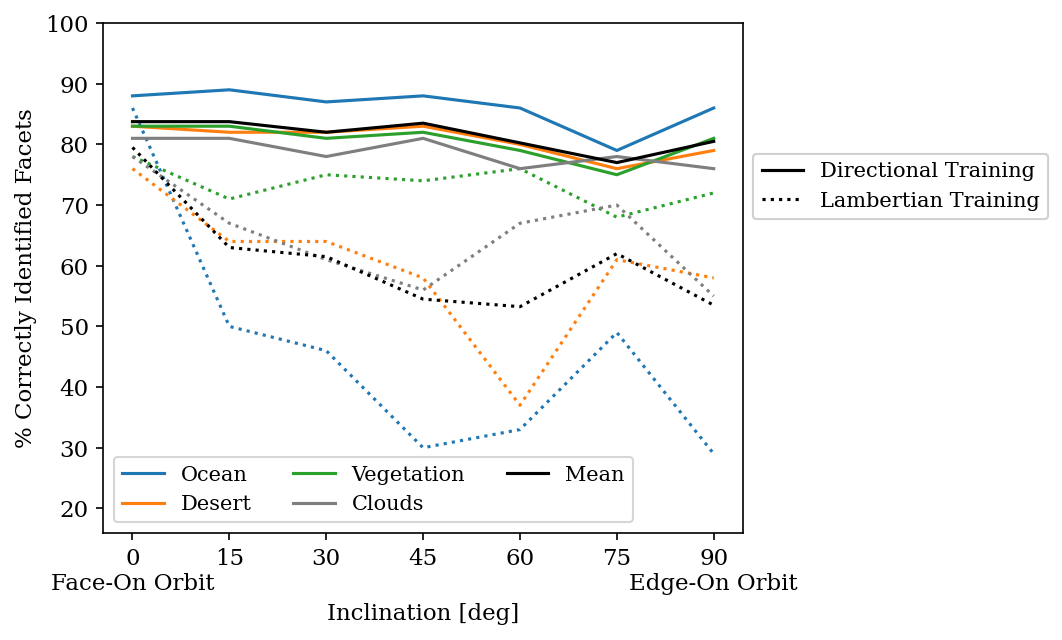

In [ ]:
xs = np.array([0, 15, 30, 45, 60, 75, 90])

lamb = np.array([[29, 58, 72, 55],
                 [49, 61, 68, 70],
                 [33, 37, 76, 67],
                 [30, 58, 74, 56],
                 [46, 64, 75, 61],
                 [50, 64, 71, 67],
                 [86, 76, 78, 78]])
# add the mean at the end of each row:
lamb = np.hstack((lamb, np.mean(lamb, axis = 1).reshape((-1,1))))

fou = np.array([[86, 79, 81, 76],
                [79, 76, 75, 78],
                [86, 80, 79, 76],
                [88, 83, 82, 81],
                [87, 82, 81, 78],
                [89, 82, 83, 81],
                [88, 83, 83, 81]])
# add the mean at the end of each row:
fou = np.hstack((fou, np.mean(fou, axis = 1).reshape((-1,1))))

plt.figure(figsize = (5.5,4.5), dpi = 150, facecolor = 'white')
plt.xticks(xs)
plt.xlabel('Inclination [deg]')
plt.xticks(xs, ['0\nFace-On Orbit', '15', '30', '45', '60', '75',
                '90\nEdge-On Orbit'])
plt.ylabel('% Correctly Identified Facets')
plt.ylim([16,100])

for i, stype in enumerate(['Ocean','Desert','Vegetation','Clouds','Mean']):

    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray', 'black'][i]
    for ys, linestyle, label in zip([lamb, fou],
                                    ['dotted', 'solid'],
                                    ['Lambertian Training', 'Directional Training']):
        if linestyle == 'solid':
            plt.plot(xs, ys[:,i][::-1], label = stype, linestyle = linestyle,
                    color = color)
        else:
            plt.plot(xs, ys[:,i][::-1], linestyle = linestyle, color = color)

legend1 = plt.legend(ncol = 3)
plt.gca().add_artist(legend1)

add_legend(labels = ['Directional Training',
                     'Lambertian Training'], y = 0.68)

plt.show()

In [ ]:
for i in [0, 15, 30, 45, 60, 75, 90]:

    axes = np.load('data/axes.npy')
    incl_vector = np.array([np.sin(i * np.pi/180), 0, np.cos(i * np.pi/180)])
    mses = np.array([np.mean((axis - incl_vector)**2) for axis in axes])
    axis_ind = np.argmin(mses)
    axis = axes[axis_ind]

    # fou_pol:
    # model = create_model(fourier = True, polarization = True, axis = int(axis_ind))
    # load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = True,
    #             maps = True, polarization = True)
    # name = 'fou_pol'
    # fou:
    model = create_model(fourier = True, polarization = False, axis = int(axis_ind))
    load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = True,
                maps = True, polarization = False)
    name = 'fou'
    # lamb:
    # model = create_model(fourier = False, polarization = False, axis = int(axis_ind))
    # load_data(i = i, axis_idx = int(axis_ind), norm = True, fourier = False,
    #             maps = True, polarization = False)
    # name = 'lamb'

    model.fit(
    curves,
    stypes,
    epochs = 1000,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = [keras.callbacks.EarlyStopping(patience=5)]
    )

    model.save_weights('models/i' + str(i) + '/' + name + '_axis' + str(int(axis_ind)))


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
lambda_119 (Lambda)             (None, 8, 10, 6)     0           input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 8, 8, 16)     304         lambda_119[0][0]                 
__________________________________________________________________________________________________
lambda_120 (Lambda)             (None, 8, 11, 16)    0           conv2d_34[0][0]                  
___________________________________________________________________________________________

KeyboardInterrupt: ignored

# Graphing

In [ ]:
xs = np.array([10, 10**2, 10**3, 10**4, 10**5, 2*10**6])

fou_pol = np.array([[92, 85, 85, 85],
                    [87, 81, 81, 81],
                    [86, 78, 77, 78],
                    [83, 73, 75, 76],
                    [76, 67, 68, 72],
                    [66, 60, 60, 66]])

# add the mean at the end of each row:
fou_pol = np.hstack((fou_pol, np.mean(fou_pol, axis = 1).reshape((-1,1))))
fou_pol = np.flip(fou_pol, axis = 0)

fou = np.array([[90, 85, 85, 84],
                [88, 80, 80, 79],
                [84, 77, 78, 77],
                [79, 73, 74, 75],
                [74, 68, 68, 70],
                [62, 59, 61, 63]])

fou = np.hstack((fou, np.mean(fou, axis = 1).reshape((-1,1))))
fou = np.flip(fou, axis = 0)

lamb_lamb = np.array([[88, 83, 85, 81],
                      [85, 82, 81, 78],
                      [83, 78, 78, 76],
                      [76, 70, 72, 76],
                      [70, 62, 64, 69],
                      [57, 51, 61, 60]])

lamb_lamb = np.hstack((lamb_lamb, np.mean(lamb_lamb, axis = 1).reshape((-1,1))))
lamb_lamb = np.flip(lamb_lamb, axis = 0)

lamb_fou = np.array([[29, 35, 77, 64],
                     [30, 48, 78, 53],
                     [35, 59, 78, 53],
                     [54, 59, 74, 58],
                     [73, 61, 68, 56],
                     [64, 52, 60, 52]])

lamb_fou = np.hstack((lamb_fou, np.mean(lamb_fou, axis = 1).reshape((-1,1))))
lamb_fou = np.flip(lamb_fou, axis = 0)

In [ ]:
# for ys in [fou_pol, fou, lamb_lamb, lamb_fou]:
#     print(ys)
#     print()

[[66.   60.   60.   66.   63.  ]
 [76.   67.   68.   72.   70.75]
 [83.   73.   75.   76.   76.75]
 [86.   78.   77.   78.   79.75]
 [87.   81.   81.   81.   82.5 ]
 [92.   85.   85.   85.   86.75]]

[[62.   59.   61.   63.   61.25]
 [74.   68.   68.   70.   70.  ]
 [79.   73.   74.   75.   75.25]
 [84.   77.   78.   77.   79.  ]
 [88.   80.   80.   79.   81.75]
 [90.   85.   85.   84.   86.  ]]

[[57.   51.   61.   60.   57.25]
 [70.   62.   64.   69.   66.25]
 [76.   70.   72.   76.   73.5 ]
 [83.   78.   78.   76.   78.75]
 [85.   82.   81.   78.   81.5 ]
 [88.   83.   85.   81.   84.25]]

[[64.   52.   12.   52.   45.  ]
 [73.   61.   68.   56.   64.5 ]
 [54.   59.   74.   58.   61.25]
 [35.   59.   78.   53.   56.25]
 [30.   48.   78.   53.   52.25]
 [29.   35.   77.   64.   51.25]]



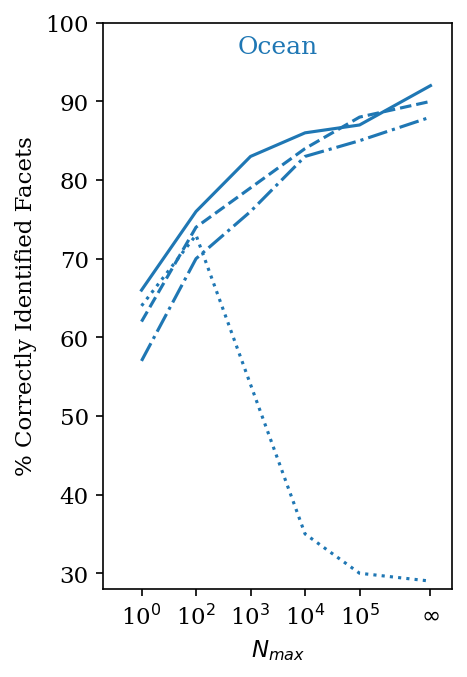

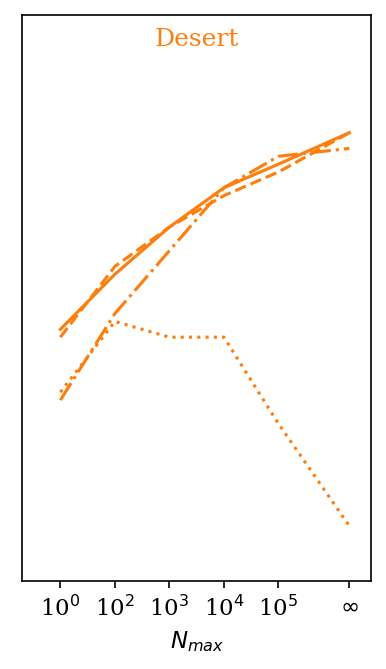

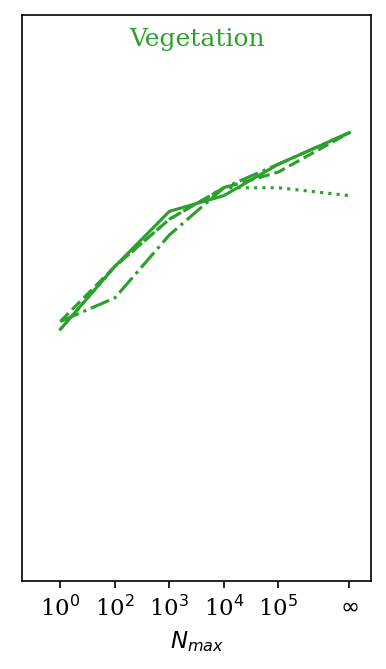

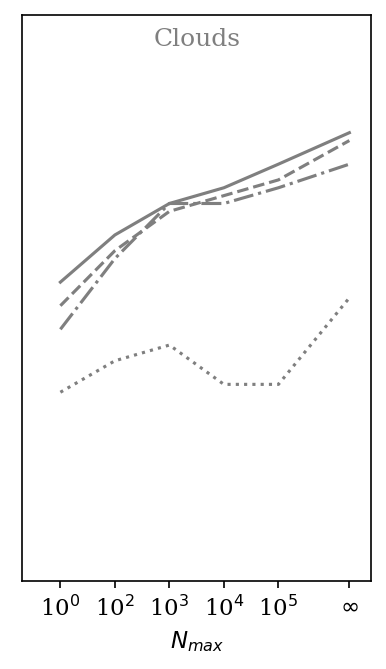

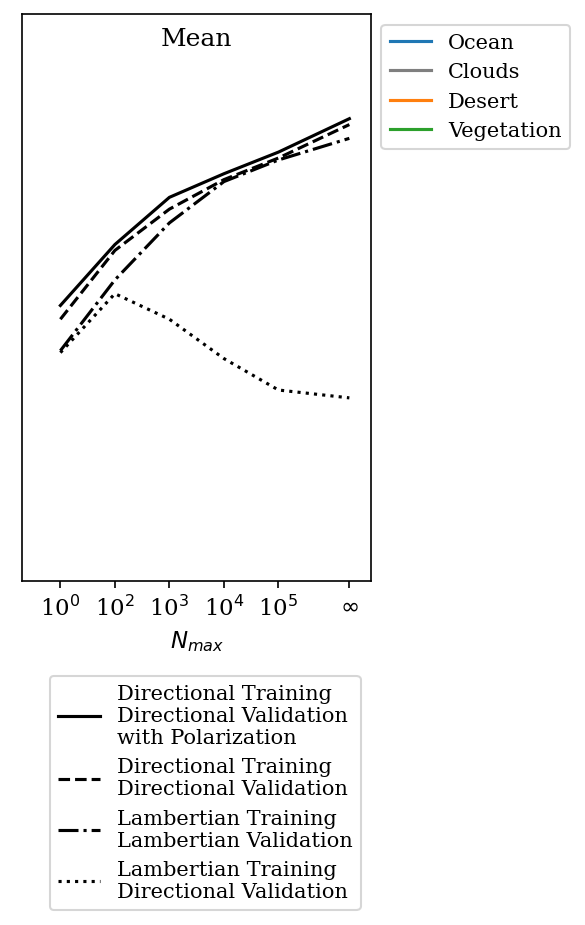

In [ ]:
for i, stype in enumerate(['Ocean','Desert','Vegetation','Clouds','Mean']):

    # if i == 4:
    #     color = 'black'
    # else:
    #     color = alb_to_rgb(albedos[i])
    # if i == 3:
    #     color *= 0.7

    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray', 'black'][i]



    plt.figure(figsize = (3,5), dpi = 150, facecolor = 'white')
    plt.xscale('log')
    plt.xticks(xs, ['10$^{0}$', '10$^2$', '10$^3$', '10$^4$', '10$^5$', '$\infty$'])
    plt.xlabel('$N_{max}$')
    if stype == 'Ocean':
        plt.ylabel('% Correctly Identified Facets')
    else:
        plt.yticks([])
    # plt.title(stype)
    plt.ylim([28,100])
    plt.xlim(2, 5*10**6)
    # plt.grid(axis = 'y', color = 'lightgray')

    for ys, linestyle, label in zip([fou_pol, fou, lamb_lamb, lamb_fou],
                                    ['solid', 'dashed', 'dashdot', 'dotted'],
                                    ['Directional Training\nDirectional Validation\nwith Polarization',
                                     'Directional Training\nDirectional Validation',
                                     'Lambertian Training\nLambertian Validation',
                                     'Lambertian Training\nDirectional Validation']):
        plt.plot(xs, ys[:,i], label = label, linestyle = linestyle,
                 color = color)
        # plt.plot(xs, ys[:,4], linestyle = linestyle, color = 'lightgray',
        #          zorder = -10)

    if stype == 'Mean':
        # surface type legend made custom:
        custom_lines = [Line2D([0], [0], color=c)
                for c in ['tab:blue', 'tab:gray', 'tab:orange', 'tab:green']]
        labels = ['Ocean','Clouds','Desert', 'Vegetation']
        legend1 = plt.legend(custom_lines, labels, bbox_to_anchor=(1, 1))
        plt.gca().add_artist(legend1)
        # normal legend
        plt.legend(bbox_to_anchor=(0, -0.15, 1, 0))


    plt.title(stype, y=0.99, pad=-12, fontsize = 12, c = color)
    plt.show()



# for ys, linestyle, label in zip([fou_pol, fou, lamb],
#                                 ['dashed', 'dotted', 'solid'],
#                                 ['fourier w/ polarization', 'fourier', 'lambertian']):


# # for ys, linestyle, label in zip([fou_pol],
# #                                 ['dashed'],
# #                                 ['fourier w/ polarization']):
#     for row, color in zip(ys.T,
#                           ['blue', 'orange', 'green', 'gray', 'black']):
#         plt.plot(xs, row, linestyle = linestyle, color = color)
#     # plt.plot(xs, ys[:,4], linestyle = linestyle, color = 'black',
#     #          label = label)

# plt.legend()